# Homework 1

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

***

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *

# 1. Pricing the Callable Bond

### Data

Use the data from the following files.
* `../data/callable_bonds_2025-02-13.xlsx`
* `../data/discount_curve_2025-02-13.xlsx`

The data contains info on the following bonds.

`Callable`
* `FHLMC 4.41 01/28/30` is a callable bond, and it is the primary object of our analysis.

`Reference` bonds for a forward price.
* `FHLMC 0.97 01/28/28`
* `FHLMC 1.25 01/29/30`

Though these are technically callable, they are far out of the money. Thus, for the purposes of this analysis, we consider the reference bonds as non-callable bonds.

These reference bonds are analyzed in optional problems at the end, but mostly you will focus on the `callable` bond.

In [2]:
FILE_BOND = '../data/callable_bonds_2025-02-13.xlsx'
FILE_CURVE = '../data/discount_curve_2025-02-13.xlsx'

KEY_CALLABLE = 'FHLMC 4.41 01/28/30'
KEY_REF_T1 = 'FHLMC 0.97 01/28/28'
KEY_REF_T2 = 'FHLMC 1 1/4 01/29/30'

### Bond Info

In [3]:
import pandas as pd

info = pd.read_excel(FILE_BOND,sheet_name='info').set_index('info')
info.style.format('{:.2%}',subset=pd.IndexSlice[["Cpn Rate"], :]).format('{:,.0f}',subset=pd.IndexSlice[["Amount Issued"], :]).format('{:%Y-%m-%d}',subset=pd.IndexSlice[["Date Quoted","Date Issued","Date Matures","Date Next Call"], :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
info,,,
CUSIP,3134GW5F9,3134GWGK6,3134HA4V2
Issuer,FREDDIE MAC,FREDDIE MAC,FREDDIE MAC
Maturity Type,CALLABLE,CALLABLE,CALLABLE
Issuer Industry,GOVT AGENCY,GOVT AGENCY,GOVT AGENCY
Amount Issued,"30,000,000","25,000,000","10,000,000"
Cpn Rate,0.97%,1.25%,4.41%
Cpn Freq,2,2,2
Date Quoted,2025-02-13,2025-02-13,2025-02-13
Date Issued,2020-10-28,2020-07-29,2025-01-28


### Quoted Values

In [4]:
quotes = pd.read_excel(FILE_BOND,sheet_name='quotes').set_index('quotes')
quotes.style.format('{:.2f}', subset=pd.IndexSlice[quotes.index[1:], :]).format('{:%Y-%m-%d}', subset=pd.IndexSlice['Date Quoted', :])

,FHLMC 0.97 01/28/28,FHLMC 1 1/4 01/29/30,FHLMC 4.41 01/28/30
quotes,,,
Date Quoted,2025-02-13,2025-02-13,2025-02-13
TTM,2.95,4.96,4.96
Clean Price,90.14,85.11,99.89
Dirty Price,90.19,85.16,100.09
Accrued Interest,0.04,0.05,0.20
YTM Call,54.24,85.40,4.45
YTM Maturity,4.57,4.65,4.43
Duration,2.92,4.81,4.50
Modified Duration,2.85,4.70,4.40


### Discount Curves

In [5]:
discs = pd.read_excel(FILE_CURVE,sheet_name='discount curve').set_index('ttm')
display(discs.head())
display(discs.tail())

,maturity date,spot rate,discount
ttm,,,
0.5,2025-08-13,0.043743,0.978597
1.0,2026-02-13,0.042890,0.958451
1.5,2026-08-13,0.042238,0.939228
2.0,2027-02-13,0.041843,0.920515
2.5,2027-08-13,0.041632,0.902117


,maturity date,spot rate,discount
ttm,,,
28.0,2053-02-13,0.040185,0.328231
28.5,2053-08-13,0.040051,0.322978
29.0,2054-02-13,0.039916,0.317851
29.5,2054-08-13,0.039791,0.312766
30.0,2055-02-13,0.039665,0.307802


***

In [6]:
# *Assumptions: We are interpolating the rates and the discount factors based on the discount/ forward curve

### 1.1.

Use the discount curve data to price both the `callable` and `reference` bonds.

For now, calculate the price of the `callable` bond as if it were non-callable. We refer to this as the `hypothetical` bond.

In [7]:
def price_bond(cusip, coupon_rate, date_quoted, date_issued, maturity_date, coupon_frequency, discount_df):
    dq, di, mdt = pd.to_datetime(date_quoted), pd.to_datetime(date_issued), pd.to_datetime(maturity_date)
    period_months = int(12 / coupon_frequency)
    coupon_dates = []
    current = mdt
    while current >= di:
        coupon_dates.append(current)
        current -= pd.DateOffset(months=period_months)
    coupon_dates.sort()
    remaining = [d for d in coupon_dates if d >= dq]
    if not remaining:
        return {'clean_price': 0.0, 'dirty_price': 0.0, 'accrued_interest': 0.0}
    times = np.array([(d - dq).days / 365 for d in remaining])
    flows = np.full(len(remaining), coupon_rate / coupon_frequency * 100.0)
    flows[-1] += 100.0
    tenors = np.array(sorted(discount_df.index.astype(float)))
    disc = discount_df.loc[tenors, 'discount'].values
    interp_disc = np.interp(times, tenors, disc)
    dirty_price = np.sum(flows * interp_disc)
    past = [d for d in coupon_dates if d <= dq]
    if past:
        last_cp = max(past)
        next_cp = min(d for d in coupon_dates if d > last_cp)
        accrual = (dq - last_cp).days / (next_cp - last_cp).days
    else:
        accrual = 0.0
    accrued_interest = coupon_rate / coupon_frequency * 100.0 * accrual
    clean_price = dirty_price - accrued_interest
    return {'cusip': cusip,'clean_price': clean_price, 'dirty_price': dirty_price, 'accrued_interest': accrued_interest}

In [8]:
ref_bond_1 = "FHLMC 0.97 01/28/28"
ref_bond_2 = "FHLMC 1 1/4 01/29/30"
callable_hypothetical_bond = "FHLMC 4.41 01/28/30"

price_3134GW5F9 = price_bond(cusip=info.loc["CUSIP"][ref_bond_1], 
                             coupon_rate=info.loc["Cpn Rate"][ref_bond_1],
                             date_quoted=info.loc["Date Quoted"][ref_bond_1], 
                             date_issued=info.loc["Date Issued"][ref_bond_1], 
                             maturity_date=info.loc["Date Matures"][ref_bond_1], 
                             coupon_frequency=info.loc["Cpn Freq"][ref_bond_1], 
                             discount_df=discs[["discount"]])

price_3134GWGK6 = price_bond(cusip=info.loc["CUSIP"][ref_bond_2],
                             coupon_rate=info.loc["Cpn Rate"][ref_bond_2],
                             date_quoted=info.loc["Date Quoted"][ref_bond_2], 
                             date_issued=info.loc["Date Issued"][ref_bond_2], 
                             maturity_date=info.loc["Date Matures"][ref_bond_2], 
                             coupon_frequency=info.loc["Cpn Freq"][ref_bond_2], 
                             discount_df=discs[["discount"]])

price_3134HA4V2 = price_bond(cusip=info.loc["CUSIP"][callable_hypothetical_bond], 
                             coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond],
                             date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                             date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                             maturity_date=info.loc["Date Matures"][callable_hypothetical_bond], 
                             coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                             discount_df=discs[["discount"]])

bond_price_dicts = [price_3134GW5F9, price_3134GWGK6, price_3134HA4V2]
bond_price_df = pd.DataFrame(bond_price_dicts)
bond_price_df = bond_price_df.rename(columns={
    'cusip': 'CUSIP',
    'clean_price': 'Clean Price',
    'dirty_price': 'Dirty Price',
    'accrued_interest': 'Accrued Interest'
}).set_index('CUSIP')
bond_price_df

,Clean Price,Dirty Price,Accrued Interest
CUSIP,,,
3134GW5F9,91.235552,91.278425,0.042873
3134GWGK6,87.179389,87.231185,0.051796
3134HA4V2,101.202418,101.397335,0.194917


### 1.2.

Calculate the forward price of the `hypothetical` bond as of the date that the `callable` bond can be exercised.

Use the information from the discount curve (and associated forward curve) to calculate this forward price.

In [9]:
def forward_price_bond(coupon_rate, date_quoted, date_issued, maturity_date, coupon_frequency, discount_df, date_call):
    dq, di, md, dc = pd.to_datetime(date_quoted), pd.to_datetime(date_issued), pd.to_datetime(maturity_date), pd.to_datetime(date_call)
    period_months = int(12 / coupon_frequency)
    coupon_dates = []
    c = md
    while c >= di:
        coupon_dates.append(c)
        c -= pd.DateOffset(months=period_months)
    coupon_dates.sort()
    coupon_dates = [d for d in coupon_dates if d >= dq]
    if not coupon_dates:
        return 0.0
    times = np.array([(d - dq).days / 365 for d in coupon_dates])
    flows = np.full(len(coupon_dates), coupon_rate / coupon_frequency * 100.0)
    flows[-1] += 100.0
    tenors = discount_df.index.astype(float).values
    disc_vals = discount_df['discount'].values
    interp_disc = np.interp(times, tenors, disc_vals)
    total_pv = np.sum(flows * interp_disc)
    mask = np.array(coupon_dates) <= dc
    sum_before_call = np.sum(flows[mask] * interp_disc[mask]) if mask.any() else 0.0
    call_time = (dc - dq).days / 365
    df_call = np.interp(call_time, tenors, disc_vals)
    return (total_pv - sum_before_call) / (df_call)

In [10]:
forward_price_3134HA4V2 = forward_price_bond(coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond],
                                             date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                                             date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                                             maturity_date=info.loc["Date Matures"][callable_hypothetical_bond], 
                                             coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                                             discount_df=discs[["discount"]],
                                             date_call=info.loc["Date Next Call"][callable_hypothetical_bond])

print(f"Forward Price of the callable bond: {info.loc["CUSIP"][callable_hypothetical_bond]} = {forward_price_3134HA4V2}")

Forward Price of the callable bond: 3134HA4V2 = 100.56610589763379


### 1.3.

The provided implied vol corresponds to the implied vol of the **rate**. Specifically,
* the forward rate corresponding to the time of expiration.
* continuously compounded.

Use the duration approximation to get the approximate implied vol corresponding to the forward price.

$$\sigma_{\text{bond fwd price}} \approx D \times \sigma_{\text{fwd rate}}\times f(T_1)$$

where $f(T_1)$ is the continuously-compounded (instantaneous) forward rate at time $T_1$.
* If you're struggling with the forward rate calc, just usse the provided spot rate at $T_1$; it will be a close approximation in this example.
* In this approximation, use the quoted duration from the table. (Yes, this is a bit circular, but we don't want to get bogged down with a duration calculation at this point.)

Report the implied vol of the bond's forward price.

In [11]:
def forward_rates_from_discounts(discount_df):
    discount_df = discount_df.sort_index()
    t = discount_df.index.values.astype(float)
    z = discount_df["discount"].values
    forward_discounts = z[1:] / z[:-1]
    forward_rates = (z[:-1] / z[1:] - 1) / (t[1:] - t[:-1])
    return pd.DataFrame(index=t[1:], data={"forward_rate": forward_rates, "forward_discount": forward_discounts})

def get_forward_rate(date_quoted, date_call, forward_rate_df):
    dq, dc = pd.to_datetime(date_quoted), pd.to_datetime(date_call)
    call_time = (dc - dq).days / 365
    times = forward_rate_df.index.astype(float).values
    rates = forward_rate_df["forward_rate"].values
    return np.interp(call_time, times, rates)

In [12]:
forward_rates = forward_rates_from_discounts(discs[["discount"]])
forward_rates.head()

,forward_rate,forward_discount
1.0,0.042038,0.979414
1.5,0.040933,0.979944
2.0,0.040658,0.980076
2.5,0.040788,0.980013
3.0,0.040795,0.980010


In [13]:
duration = quotes.loc["Duration"][callable_hypothetical_bond]
print(f"Duration of the bond: {duration}")
      
implied_vol_rate = quotes.loc["Implied Vol"][callable_hypothetical_bond]
print(f"Implied Volatility of Rate: {implied_vol_rate}")

forward_rate = get_forward_rate(date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                               date_call=info.loc["Date Next Call"][callable_hypothetical_bond],
                               forward_rate_df=forward_rates)
print(f"Forward Rate: {forward_rate}")

implied_vol_bond_forward_price = duration * implied_vol_rate *forward_rate
print(f"\nImplied vol of the bond: {info.loc["CUSIP"][callable_hypothetical_bond]}'s Forward Price = {implied_vol_bond_forward_price}")

Duration of the bond: 4.496738331374342
Implied Volatility of Rate: 23.87982940673828
Forward Rate: 0.04079464781362262

Implied vol of the bond: 3134HA4V2's Forward Price = 4.380584120022552


### 1.4.

For the `callable` bond, report Black's value of the embedded call option.
* Use this to report the value of the `callable` bond.
* How does it compare to the actual market price?

For the calculation of the option, use...
* the quoted `Implied Vol` calculated above.
* forward price of the `hypothetical` bond calculated above.
* provided discount factor

#### Simplifications
Note that in this calculation we are making a few simplifications.
* We are simplifying that the `callable` bond is European exercise with an exercise date as reported in `Date Next Call` above. 
* In reality, it is Bermudan, with quarterly exercise dates after the first exercise date.
* The time-to-exercise is not a round number, but you only have discount factors at rounded time-to-maturities. Just use the closest discount factor.

In [14]:
def black_option_value(discount_df, F, K, implied_vol, date_quoted, date_call):
    dq, dc = pd.to_datetime(date_quoted), pd.to_datetime(date_call)
    T = (dc - dq).days / 365
    tenors = discount_df.index.astype(float).values
    disc_vals = discount_df["discount"].values
    df_T = np.interp(T, tenors, disc_vals)
    sigma_sqrt_T = implied_vol * np.sqrt(T)
    d1 = (np.log(F / K) + 0.5 * implied_vol**2 * T) / sigma_sqrt_T
    d2 = d1 - sigma_sqrt_T
    call_value = df_T * (F * norm.cdf(d1) - K * norm.cdf(d2))
    put_value = df_T * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    return {"call": call_value, "put": put_value}

In [15]:
value_embedded_option = black_option_value(discount_df=discs[["discount"]],
                                          F=forward_price_3134HA4V2,
                                          K=info.loc["Strike"][callable_hypothetical_bond],
                                          implied_vol=implied_vol_bond_forward_price/100,
                                          date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond],
                                          date_call=info.loc["Date Next Call"][callable_hypothetical_bond])

call_option_value = value_embedded_option['call']
print(f"Call Option Value: {call_option_value}")

price_of_bond = price_3134HA4V2['dirty_price']
print(f"Vanilla Price of the bond: {price_of_bond}")

price_of_callable_bond = price_of_bond - call_option_value
print(f"\nCalculated Dirty Price of the Callable bond: {price_of_callable_bond}")
print(f"Quoted Dirty Price of the Callable bond: {quotes.loc["Dirty Price"][callable_hypothetical_bond]}")

Call Option Value: 2.9262691056851917
Vanilla Price of the bond: 101.39733547115193

Calculated Dirty Price of the Callable bond: 98.47106636546674
Quoted Dirty Price of the Callable bond: 100.089


The calculated dirty price of the bond is less than the quoted market price of the bond. 
This could imply that the market is pricing that there is a lower probability of the bond to be called. 

### 1.5.

Calculate the YTM of the callable bond, assuming that...
* it can never be called. (This is the `hypothetical` bond we analyzed above.)
* it will certainly be called.

How do these compare to the quoted YTM Called and YTM Maturity in the table?

In [16]:
def bond_ytm(price, coupon_rate, date_quoted, date_issued, maturity_date, coupon_frequency):
    dq, di, md = pd.to_datetime(date_quoted), pd.to_datetime(date_issued), pd.to_datetime(maturity_date)
    period_months = int(12 / coupon_frequency)
    coupon_dates = []
    c = md
    while c >= di:
        coupon_dates.append(c)
        c -= pd.DateOffset(months=period_months)
    coupon_dates.sort()
    future_dates = [d for d in coupon_dates if d > dq]
    if not future_dates:
        return 0.0
    times = np.array([(d - dq).days / 365 for d in future_dates])
    flows = np.full(len(times), coupon_rate / coupon_frequency * 100.0)
    flows[-1] += 100.0
    def pv_diff(y):
        return np.sum(flows / ((1 + y)**times)) - price
    return brentq(pv_diff, -0.999999, 10.0)

In [17]:
price_3134HA4V2_no_call = price_bond(cusip=info.loc["CUSIP"][callable_hypothetical_bond], 
                             coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond],
                             date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                             date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                             maturity_date=info.loc["Date Matures"][callable_hypothetical_bond],
                             coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                             discount_df=discs[["discount"]])

ytm_no_call = bond_ytm(price=price_3134HA4V2_no_call['dirty_price'], 
                            coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond], 
                            date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                            date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                            maturity_date=info.loc["Date Matures"][callable_hypothetical_bond],
                            coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond])

price_3134HA4V2_call = price_bond(cusip=info.loc["CUSIP"][callable_hypothetical_bond], 
                             coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond],
                             date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                             date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                             maturity_date=info.loc["Date Next Call"][callable_hypothetical_bond], 
                             coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                             discount_df=discs[["discount"]])

ytm_called = bond_ytm(price=price_3134HA4V2_call['dirty_price'], 
                            coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond], 
                            date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                            date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                            maturity_date=info.loc["Date Next Call"][callable_hypothetical_bond], 
                            coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond])

print(f"Calculated YTM of the callable bond, assuming that it can never be called: {ytm_no_call*100}")
print(f"Quoted YTM of the callable bond, assuming that it can never be called: {quotes.loc["YTM Maturity"][callable_hypothetical_bond]}")

print(f"\nCalculated YTM of the callable bond, assuming that it will certainly be called: {ytm_called*100}")
print(f"Quoted YTM of the callable bond, assuming that it will certainly be called: {quotes.loc["YTM Call"][callable_hypothetical_bond]}")

Calculated YTM of the callable bond, assuming that it can never be called: 4.179318850043794
Quoted YTM of the callable bond, assuming that it can never be called: 4.433845268135366

Calculated YTM of the callable bond, assuming that it will certainly be called: 4.197841082104597
Quoted YTM of the callable bond, assuming that it will certainly be called: 4.448321150444964


- The calculated YTM of a bond that is assumed to be never called is lower than the quoted YTM Maturity.
- This is similar for the bond that is assumed to be definitely called. 

Assuming the model is correct, the differences between the calculated and quoted yields could imply several things:
- The market may be incorporating factors (like liquidity) that aren’t fully captured in the model. 
- The higher market yield might reflect an embedded risk premium for callable bonds, compensating investors for the uncertainty regarding the call event, even though the model accounts for call scenarios.
- If the model is right, the discrepancies suggest that while it captures the basic mechanics of callable bonds, real-world pricing involves additional market nuances that lead to higher yields.

### 1.6.

Calculate the duration of...
* the `hypothetical` bond
* the `callable` bond

How do these compare to the quoted duration in the table?

For the callable bond, calculate duration numerically by modifying the spot rates up and down by 1bp and seeing how it changes the valuation of parts `1.1`-`1.3`.

In [18]:
def bond_duration(coupon_rate, date_quoted, date_issued, maturity_date, coupon_frequency, discount_df):
    dq, di, md = pd.to_datetime(date_quoted), pd.to_datetime(date_issued), pd.to_datetime(maturity_date)
    period_months = int(12 / coupon_frequency)
    coupon_dates = []
    c = md
    while c >= di:
        coupon_dates.append(c)
        c -= pd.DateOffset(months=period_months)
    coupon_dates.sort()
    future_dates = [d for d in coupon_dates if d >= dq]
    if not future_dates:
        return 0.0
    times = np.array([(d - dq).days / 365 for d in future_dates])
    flows = np.full(len(times), coupon_rate / coupon_frequency * 100.0)
    flows[-1] += 100.0
    tenors = discount_df.index.astype(float).values
    disc_vals = discount_df["discount"].values
    interp_disc = np.interp(times, tenors, disc_vals)
    pv_flows = flows * interp_disc
    price = np.sum(pv_flows)
    weighted_times = times * pv_flows
    return np.sum(weighted_times) / price

In [19]:
duration_hypothetical_bond = bond_duration(coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond], 
                                           date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                                           date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                                           maturity_date=info.loc["Date Matures"][callable_hypothetical_bond],
                                           coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                                           discount_df=discs[["discount"]])

print(f"Calculated Duration of hypothetical bond: {duration_hypothetical_bond}")
print(f"Quoted Duration of callable bond: {quotes.loc["Duration"][callable_hypothetical_bond]}")

Calculated Duration of hypothetical bond: 4.5035673767017945
Quoted Duration of callable bond: 4.496738331374342


In [20]:
def shift_discount_factors(discount_df, shift):
    tenors = discount_df.index.astype(float)
    new_discounts = discount_df["discount"].values * np.exp(-shift * tenors)
    return pd.DataFrame(new_discounts.values, index=discount_df.index, columns=["discount"])

In [21]:
df_shift_up = shift_discount_factors(discs[["discount"]], 0.0001)
df_shift_down = shift_discount_factors(discs[["discount"]], -0.0001)
# 1.1
P0 =  price_bond(cusip=info.loc["CUSIP"][callable_hypothetical_bond], 
                             coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond],
                             date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                             date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                             maturity_date=info.loc["Date Matures"][callable_hypothetical_bond], 
                             coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                             discount_df=discs[["discount"]])['dirty_price']

P_up = price_bond(cusip=info.loc["CUSIP"][callable_hypothetical_bond], 
                             coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond],
                             date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                             date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                             maturity_date=info.loc["Date Matures"][callable_hypothetical_bond], 
                             coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                             discount_df=df_shift_up[["discount"]])['dirty_price']

P_down = price_bond(cusip=info.loc["CUSIP"][callable_hypothetical_bond], 
                             coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond],
                             date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                             date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                             maturity_date=info.loc["Date Matures"][callable_hypothetical_bond], 
                             coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                             discount_df=df_shift_down[["discount"]])['dirty_price']

print(f"Price of Vanilla Bond with original discount curve: {P0}")
print(f"Price of Vanilla Bond with 1bp upshift in discount curve: {P_up}")
print(f"Price of Vanilla Bond with 1bp downshift in discount curve: {P_down}")

Price of Vanilla Bond with original discount curve: 101.39733547115193
Price of Vanilla Bond with 1bp upshift in discount curve: 101.35167887680343
Price of Vanilla Bond with 1bp downshift in discount curve: 101.4430139202951


In [22]:
# 1.2
F0 = forward_price_bond(coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond],
                                             date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                                             date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                                             maturity_date=info.loc["Date Matures"][callable_hypothetical_bond], 
                                             coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                                             discount_df=discs[["discount"]],
                                             date_call=info.loc["Date Next Call"][callable_hypothetical_bond])

F_up = forward_price_bond(coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond],
                                             date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                                             date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                                             maturity_date=info.loc["Date Matures"][callable_hypothetical_bond], 
                                             coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                                             discount_df=df_shift_up[["discount"]],
                                             date_call=info.loc["Date Next Call"][callable_hypothetical_bond])

F_down = forward_price_bond(coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond],
                                             date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                                             date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                                             maturity_date=info.loc["Date Matures"][callable_hypothetical_bond], 
                                             coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                                             discount_df=df_shift_down[["discount"]],
                                             date_call=info.loc["Date Next Call"][callable_hypothetical_bond])

print(f"Forward Price of the callable bond: {info.loc["CUSIP"][callable_hypothetical_bond]} with original discount curve = {F0}")
print(f"Forward Price of the callable bond: {info.loc["CUSIP"][callable_hypothetical_bond]} with 1bp upshift in discount curve = {F_up}")
print(f"Forward Price of the callable bond: {info.loc["CUSIP"][callable_hypothetical_bond]} with 1bp downhift in discount curve = {F_down}")

Forward Price of the callable bond: 3134HA4V2 with original discount curve = 100.56610589763379
Forward Price of the callable bond: 3134HA4V2 with 1bp upshift in discount curve = 100.5466080330534
Forward Price of the callable bond: 3134HA4V2 with 1bp downhift in discount curve = 100.58560761339251


In [23]:
# 1.3
forward_rates = forward_rates_from_discounts(discs[["discount"]])
forward_rates_up = forward_rates_from_discounts(df_shift_up[["discount"]])
forward_rates_down = forward_rates_from_discounts(df_shift_down[["discount"]])

duration = quotes.loc["Duration"][callable_hypothetical_bond]      
implied_vol_rate = quotes.loc["Implied Vol"][callable_hypothetical_bond]

forward_rate = get_forward_rate(date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                               date_call=info.loc["Date Next Call"][callable_hypothetical_bond],
                               forward_rate_df=forward_rates)
forward_rate_up = get_forward_rate(date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                               date_call=info.loc["Date Next Call"][callable_hypothetical_bond],
                               forward_rate_df=forward_rates_up)
forward_rate_down = get_forward_rate(date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                               date_call=info.loc["Date Next Call"][callable_hypothetical_bond],
                               forward_rate_df=forward_rates_down)

implied_vol_bond_forward_price = duration * implied_vol_rate *forward_rate
implied_vol_bond_forward_price_up = duration * implied_vol_rate *forward_rate_up
implied_vol_bond_forward_price_down = duration * implied_vol_rate *forward_rate_down

print(f"Implied vol of the bond: {info.loc["CUSIP"][callable_hypothetical_bond]}'s Forward Price with original forward curve = {implied_vol_bond_forward_price}")
print(f"Implied vol of the bond: {info.loc["CUSIP"][callable_hypothetical_bond]}'s Forward Price with 1bp upshift in forward curve = {implied_vol_bond_forward_price_up}")
print(f"Implied vol of the bond: {info.loc["CUSIP"][callable_hypothetical_bond]}'s Forward Price with 1bp downshift in forward curve = {implied_vol_bond_forward_price_down}")

Implied vol of the bond: 3134HA4V2's Forward Price with original forward curve = 4.380584120022552
Implied vol of the bond: 3134HA4V2's Forward Price with 1bp upshift in forward curve = 4.391541557586204
Implied vol of the bond: 3134HA4V2's Forward Price with 1bp downshift in forward curve = 4.369627230317124


In [24]:
# 1.4
c0 = black_option_value(discount_df=discs[["discount"]],
                                          F=F0,
                                          K=info.loc["Strike"][callable_hypothetical_bond],
                                          implied_vol=implied_vol_bond_forward_price/100,
                                          date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond],
                                          date_call=info.loc["Date Next Call"][callable_hypothetical_bond])['call']

c_up = black_option_value(discount_df=df_shift_up[["discount"]],
                                          F=F_up,
                                          K=info.loc["Strike"][callable_hypothetical_bond],
                                          implied_vol=implied_vol_bond_forward_price_up/100,
                                          date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond],
                                          date_call=info.loc["Date Next Call"][callable_hypothetical_bond])['call']

c_down = black_option_value(discount_df=df_shift_down[["discount"]],
                                          F=F_down,
                                          K=info.loc["Strike"][callable_hypothetical_bond],
                                          implied_vol=implied_vol_bond_forward_price_down/100,
                                          date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond],
                                          date_call=info.loc["Date Next Call"][callable_hypothetical_bond])['call']
p_cb = P0 - c0
p_cb_up = P_up - c_up
p_cb_down = P_down - c_down

print(f"Calculated Dirty Price of the Callable bond with original discount curve: {p_cb}")
print(f"Calculated Dirty Price of the Callable bond with 1bp upshift in discount curve: {p_cb_up}")
print(f"Calculated Dirty Price of the Callable bond with 1bp downshift in discount curve: {p_cb_down}")

Calculated Dirty Price of the Callable bond with original discount curve: 98.47106636546674
Calculated Dirty Price of the Callable bond with 1bp upshift in discount curve: 98.42902064307094
Calculated Dirty Price of the Callable bond with 1bp downshift in discount curve: 98.51311089307521


In [25]:
duration_callable = (1/p_cb)*(p_cb_down-p_cb_up)/((2 * 0.0001))
print(f"Calculated Duration of Callable Bond: {duration_callable}")
print(f"Quoted Duration of Callable Bond: {quotes.loc["Duration"][callable_hypothetical_bond]}")

Calculated Duration of Callable Bond: 4.269794829486885
Quoted Duration of Callable Bond: 4.496738331374342


- The calculated duration of the callable bond is lower than the actual quoted duration of the callable bond
- This could be because the embedded option could be limiting the sensitivity with respect to the interest rates. 

### 1.7.

Calculate the OAS of the `callable` bond.

How does it compare to the quoted OAS?

Recall that the OAS is the parallel shift in the spot curve needed to align the modeled value to the market quote.

In [26]:
def calculate_oas(market_price, cusip, coupon_rate, date_quoted, date_issued, maturity_date, coupon_frequency, discount_df, date_call, K, implied_vol, tol=1e-8):
    def model_price(shift):
        df_shift = shift_discount_factors(discount_df, shift)
        non_callable_price = price_bond(cusip, coupon_rate, date_quoted, date_issued, maturity_date, coupon_frequency, df_shift)['dirty_price']
        F = forward_price_bond(coupon_rate, date_quoted, date_issued, maturity_date, coupon_frequency, df_shift, date_call)
        option_val = black_option_value(df_shift, F, K, implied_vol, date_quoted, date_call)["call"]
        return non_callable_price - option_val

    def f(shift):
        return model_price(shift) - market_price

    a, b = -0.05, 0.05
    fa, fb = f(a), f(b)
    expansion = 2
    while fa * fb > 0:
        a *= expansion
        b *= expansion
        fa, fb = f(a), f(b)
        if abs(a) > 1e3 or abs(b) > 1e3:
            raise ValueError("Unable to bracket the root within a reasonable range.")
    return brentq(f, a, b, xtol=tol)

In [29]:
oas = calculate_oas(market_price=quotes.loc["Dirty Price"][callable_hypothetical_bond],
                    cusip=info.loc["CUSIP"][callable_hypothetical_bond], 
                    coupon_rate=info.loc["Cpn Rate"][callable_hypothetical_bond],
                    date_quoted=info.loc["Date Quoted"][callable_hypothetical_bond], 
                    date_issued=info.loc["Date Issued"][callable_hypothetical_bond], 
                    maturity_date=info.loc["Date Matures"][callable_hypothetical_bond], 
                    coupon_frequency=info.loc["Cpn Freq"][callable_hypothetical_bond], 
                    discount_df=discs[["discount"]],
                    date_call=info.loc["Date Next Call"][callable_hypothetical_bond],
                    K=info.loc["Strike"][callable_hypothetical_bond],
                    implied_vol=implied_vol_bond_forward_price/100)
print(f"Calculated Option Adjusted Price: {quotes.loc["OAS Spread"][callable_hypothetical_bond] + oas}")
print(f"Quoted Option Adjusted Price: {(quotes.loc["OAS Spread"][callable_hypothetical_bond])}")
print(f"Difference in OAS Spread: {oas}")

Calculated Option Adjusted Price: -26.772667381513045
Quoted Option Adjusted Price: -26.76808540103936
Difference in OAS Spread: -0.0045819804736848165


- Both the model and market quote yield negative Option Adjusted Prices, indicating that the callable feature detracts from the bond’s price.
- The model values the call feature as slightly more detrimental than the market does.
- A difference of –1.03 in the OAS implies that, under the model’s assumptions, investors should demand roughly an extra 1.03 percentage points in yield to be compensated for the call risk relative to market pricing.
- The model might be accounting for factors such as higher call probabilities, more adverse interest rate scenarios, or a more conservative view of embedded option risk, that are not fully reflected in the market quote.
- This suggests that, from the model’s perspective, the callable bond is slightly more unattractive than the market price implies, meaning there is an additional risk premium that should be factored into the yield.

### 1.8. Optional

Calculate the forward price of the `hypothetical` bond, but try doing so by using the `reference` bonds to calculate the forward price.
* The prices of these reference bonds would be discount factors, and we simply take the ratio.
* However, the coupons of the bonds do not align, so you need to adjust for this fact.

### 1.9. Optional

Analyze what we have called the `reference` bonds as `callable` bonds. 

Calculate its value, YTMs, duration, and OAS.

***

# 2. Pricing Floors

### Data

The file `data/cap_curves_2025-01-31.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.

In [44]:
df_cap_curves = pd.read_excel("../data/cap_curves_2025-01-31.xlsx", sheet_name="rate curves 2025-01-31").set_index("tenor").rename(columns={"discounts":"discount"})
df_cap_curves

,swap rates,spot rates,discount,forwards,flat vols,fwd vols
tenor,,,,,,
0.25,0.042340,0.042340,0.989526,NaN,NaN,NaN
0.50,0.041854,0.041852,0.979398,0.041364,0.101500,0.101500
0.75,0.041404,0.041397,0.969584,0.040489,0.116946,0.128478
1.00,0.041029,0.041018,0.960012,0.039882,0.132391,0.154562
1.25,0.040458,0.040438,0.950950,0.038117,0.159421,0.219138
1.50,0.040142,0.040117,0.941881,0.038514,0.180856,0.239613
1.75,0.039966,0.039940,0.932816,0.038873,0.197446,0.254106
2.00,0.039902,0.039877,0.923708,0.039440,0.209941,0.261605
2.25,0.039717,0.039688,0.914976,0.038173,0.219090,0.263323


### 2.1.

Recall that a floor is a portfolio of floorlets which
* depend on the realized interest rate one quarter before the expiration.
* each have the same strike interest rate.

Use Black's formula to price **just one floorlet**
* expiring at `T=3`
* struck at the `T=3` swap rate
* notional of `100`
* quarterly frequency

In [93]:
def black_option_value_cap_floor(discount_df, forward_df, K, implied_vol, date_quote, date_resolve, date_execute):
    dq, dr, de = pd.to_datetime(date_quote), pd.to_datetime(date_resolve), pd.to_datetime(date_execute)
    Tr = (dr - dq).days / 365
    Te = (de - dq).days / 365
    tenors = discount_df.index.astype(float).values
    disc_vals = discount_df["discount"].values
    df_Te = np.interp(Te, tenors, disc_vals)
    sigma_sqrt_Tr = implied_vol * np.sqrt(Tr)
    d1 = (np.log(F / K) + 0.5 * implied_vol**2 * Tr) / sigma_sqrt_Tr
    d2 = d1 - sigma_sqrt_Tr
    call_value = df_Te * (F * norm.cdf(d1) - K * norm.cdf(d2))
    put_value = df_Te * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    return {"call": call_value, "put": put_value}

In [94]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

T=3
N = 100
freqfloor = 4
strike = 
floorlet_val = N*(1/freqfloor)*black_option_value_cap_floor(df_cap_curves[["discount"]], df_cap_curves.loc[T, "forwards"], df_cap_curves.loc[T, "swap rates"], df_cap_curves.loc[T, "fwd vols"], datetime.now(), datetime.now() + relativedelta(months=33), datetime.now() + relativedelta(months=36))['put']
floorlet_val

0.14638722934555146

### 2.2.

Use Black's formula to price the entire floor with expiration of `T=3`.

The floor has floorlets at `quarterly` frequency, except the first quarter.

In [ ]:
def price_cap(T, N, freqfloor, df):
    # Select tenors between 0.5 and T (exclude T=0.25)
    maturities = np.arange(1/freqfloor,T+1/freqfloor,1/freqfloor)
    floorlets = pd.DataFrame(index=maturities,columns=['price'])
    
    for i, Tval in enumerate(floorlets.index):
        if i==0:
            floorlets.loc[Tval] = 0
        else:
            floorlets.loc[Tval] = notional * (1/freqfloor) * black_option_value_cap_floor(df_cap_curves[["discount"]], df_cap_curves.loc[Tval, "forwards"], df_cap_curves.loc[3, "swap rates"], df_cap_curves.loc[Tval, "fwd vols"], datetime.now(), datetime.now() + relativedelta(months=12*Tval-12/freqfloor), datetime.now() + relativedelta(months=12*Tval))['put']
    display(floorlets)
    floor = floorlets.sum().to_frame().rename(columns={0:'floor'})
    return floor

In [95]:
def price_floor(T, notional ):
    # Select tenors between 0.5 and T (exclude T=0.25)
    maturities = np.arange(1/freqfloor,T+1/freqfloor,1/freqfloor)
    floorlets = pd.DataFrame(index=maturities,columns=['price'])
    
    for i, Tval in enumerate(floorlets.index):
        if i==0:
            floorlets.loc[Tval] = 0
        else:
            floorlets.loc[Tval] = notional * (1/freqfloor) * black_option_value_cap_floor(df_cap_curves[["discount"]], df_cap_curves.loc[Tval, "forwards"], df_cap_curves.loc[3, "swap rates"], df_cap_curves.loc[Tval, "fwd vols"], datetime.now(), datetime.now() + relativedelta(months=12*Tval-12/freqfloor), datetime.now() + relativedelta(months=12*Tval))['put']
    display(floorlets)
    floor = floorlets.sum().to_frame().rename(columns={0:'floor'})
    return floor

In [96]:
# Compute the floor price
floor_price = price_floor(3, 100, df_cap_curves)
floor_price

,price
0.25,0
0.50,0.005841
0.75,0.026266
1.00,0.048518
1.25,0.100414
1.50,0.112309
1.75,0.12288
2.00,0.128244
2.25,0.149273
2.50,0.147831


,floor
price,1.133915


***

# 3. Stripping Caps

### Data

Continue with the file `data/cap_curves_2025-01-31.xlsx`.

### 3.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [100]:
# df_cap_curves.set_index("tenor", inplace=True)
df_cap_curves.rename(columns={"discount": "discounts"},inplace=True)
capcurves = flat_to_forward_vol(df_cap_curves)
display(capcurves.head())
cap_prices = capcurves[['cap prices']].iloc[1:]
cap_prices.head()

,flat vols,fwd vols,cap prices
tenor,,,
0.25,NaN,NaN,NaN
0.50,0.101500,0.101500,0.015175
0.75,0.116946,0.128478,0.045982
1.00,0.132391,0.154562,0.093612
1.25,0.159421,0.219138,0.170663


,cap prices
tenor,
0.50,0.015175
0.75,0.045982
1.00,0.093612
1.25,0.170663
1.50,0.266562


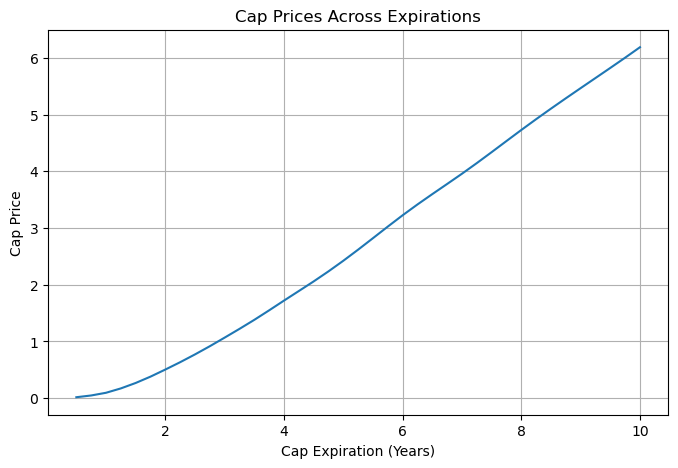

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(cap_prices.index, cap_prices, linestyle='-')
plt.xlabel("Cap Expiration (Years)")
plt.ylabel("Cap Price")
plt.title("Cap Prices Across Expirations")
plt.grid()
plt.show()

### 3.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

In [35]:
forward_vols = capcurves.loc[capcurves.index[1:], 'fwd vols']
print("Forward Volatility")
display(forward_vols.head())

flat_vols = capcurves.loc[capcurves.index[1:], 'flat vols']
print("Flat Volatility")
display(flat_vols.head())

Forward Volatility


tenor
0.50    0.101500
0.75    0.128478
1.00    0.154562
1.25    0.219138
1.50    0.239613
Name: fwd vols, dtype: float64

Flat Volatility


tenor
0.50    0.101500
0.75    0.116946
1.00    0.132391
1.25    0.159421
1.50    0.180856
Name: flat vols, dtype: float64

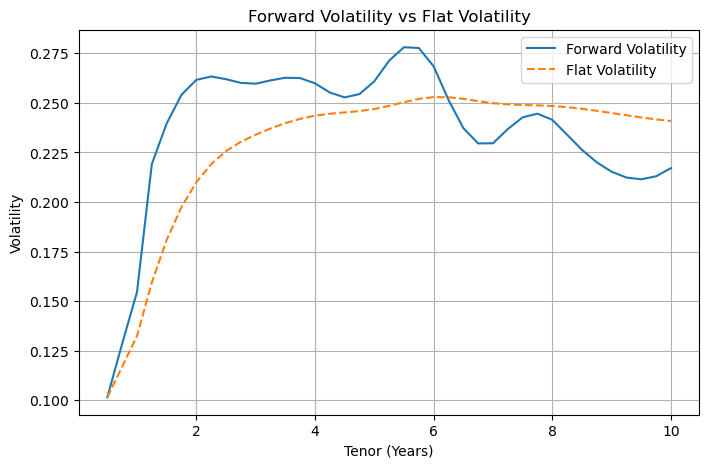

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(forward_vols.index, forward_vols, linestyle='-', label="Forward Volatility")
plt.plot(flat_vols.index, flat_vols, linestyle='--', label="Flat Volatility")
plt.xlabel("Tenor (Years)")
plt.ylabel("Volatility")
plt.title("Forward Volatility vs Flat Volatility")
plt.legend()
plt.grid()
plt.show()

***